# Readme
+ Section 1 of this notebook trains the GAN on the optimization solutions, and outputs the initial solutions using the generator. Run section 1 after inputting the name of the experiment you would like to run at the beginning of section 1.2.
    + The generated raw solutions along with the plots of accuracy and loss are stored in ./CGAN/images
    + The input data for the selected experiment is stored in ./CGAN/input_data/
    + The final TF model is stored in ./CGAN/saved_model/

+ Move the data you like to analyze from ./CGAN/images/ to ./Data/

+ Section 2 of this notebook runs the evaluation function on the generated solutions, and outputs the stats and metrics associated with the generated solutions. Run section 2 after:
    + determining the name(s) of the experiment(s) and the configurations in lines 3-9 of section 2.3 for running the evaluation function,
    + determining the name(s) of the experiment(s) and the configurations in lines 15-17 of section 2.4 for calculating the hypervolumes, and
    + making sure the filenames listed in lines 2-15 of section 2.2 are those you have moved from ./CGAN/images/ to ./Data/.
    
+ You can find the complementary solutions in ./Data/ and the plots in ./Figures/. The rest of the stats are printed to the console.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 Train the C-GAN and output the initial solutions

## 1.1 Initialize

In [1]:
'''
Taken from https://github.com/eriklindernoren/Keras-GAN/tree/master/cgan

Modified by Author
Last modified on 1/22/2021
'''

from __future__ import print_function, division

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam


import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from collections import deque

In [4]:
import os
os.chdir('/content/drive/MyDrive/GAN_GA_100_Percent_EV_Shared/GAN_GA_100_Percent_EV_Shared')

## 1.2 Main (Input Data and Train CGAN)

In [5]:
#  Set a name to distinguish the generated logs, visualizations, and models
run_name = 'EV+EnergySystem'
# Determine the name of the experiment you want to run
experiment = '1'
result_file_name = 'Results_EV_100_Percent.csv'
# Determine if you want the long runs or short runs
long_run = True

### 1.2.1 Input Data

In [6]:
# Constants for loading the dataset
max_site_area = 10**6
max_FAR = 5
max_gfa = max_site_area*max_FAR
error_tol = 1.15




# Constants for plotting the filtered plots
# LCC_Cutoff = 10 # float('inf') # k$/m2
CO2_Cutoff = float('inf') # T-CO2/m2




# Constants for evaluating the solutions
# Num_Sites = 4
Num_Buildings = 21
Num_Decision_Vars = Num_Buildings + 2
Type_Max = 7
# len_of_indiv = 11 # After adding the plant location


LCC_Var = Num_Buildings+5
CO2_Var = Num_Buildings+6
LCC_w_o_EV_from_Grid_Var = Num_Buildings+7
# WalkScore_Var = Num_Sites+15
GFA_Var = Num_Buildings+7+Type_Max+3
FAR_Var = Num_Buildings+7+Type_Max+1
EV_Ratio_Var = Num_Buildings+3


CHPType_Var = Num_Buildings
ChillerType_Var = Num_Buildings+1





# Import and filter the file `filename` based on several conditions
def DF_Filter(filename): # Similar to the one in Plots_Paper_One.py               
    file = np.loadtxt(filename, dtype='float', delimiter=',')
    inputDF = pd.DataFrame(file)

    
    
    print('+++++ processing %s +++++\n'%(filename))
    
    print('Count duplicates:')
    condition1 = inputDF.duplicated() == True
    print(inputDF[condition1][GFA_Var].count())
    
    
    print('Count under the min GFA:') # Count non-trivial neighborhoods
    condition2 = inputDF[GFA_Var] <= 1/error_tol#<=647497/10
    print(inputDF[condition2][GFA_Var].count())
    
    
    print('Count over the max GFA:')
    condition3 = inputDF[GFA_Var] >= max_gfa*error_tol
    print(inputDF[condition3][GFA_Var].count())
    
    
    print('Count over the max Site GFA:')
    condition4 = inputDF[GFA_Var]/inputDF[FAR_Var] >= max_site_area*error_tol
    print(inputDF[condition4][GFA_Var].count())


    # Normalizing the LCC and CO2 objectives
    print('Normalizing the LCC and CO2 Obj Fxns')
    inputDF[LCC_Var] /= inputDF[GFA_Var] # Normalizing LCC ($/m2)
    inputDF[CO2_Var] /= inputDF[GFA_Var] # Normalizing CO2 (Tonnes/m2)


    # Filtering the inadmissible results
    Filtered = ~(condition1 | condition2 | condition3 | condition4)
    inputDF = inputDF[Filtered]
    print('Count of valid answers: %d out of %d'%(len(inputDF), len(file)))


    print("Lowest LCC considered in training data:%.2f"%np.min(inputDF[LCC_Var]))
    print("Highest LCC considered in training data:%.2f"%np.max(inputDF[LCC_Var]))
    print("Lowest CO2 considered in training data: %.2f"%np.min(inputDF[CO2_Var]))
    print("Highest CO2 considered in training data: %.2f"%np.max(inputDF[CO2_Var]))

    inputDF.reset_index(inplace=True, drop=True)
    
    return inputDF


# Convert the raw input data into training features and labels vectors
def load_data():
    ## IMPORT DATA       
    print('loading data')
    filenames = [result_file_name]
    # DFNames = ['CCHP+Network']
    DF = DF_Filter(filenames[0])

    ## Set the range of input variables for the NN, then import the train variables
    inputRange = list(range(Num_Decision_Vars))
    # Define X
    X = DF.iloc[:,inputRange]
    # Define y
    outputRange = [LCC_Var, CO2_Var] # THESE ARE NORMALIZED IN DF_Filter
    y = DF.iloc[:, outputRange]
    


    
    print('Scaling data')
    # Scale X
    x = X.values #returns a numpy array
    std_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    X_Scaler = std_scaler.fit(x)
    X = X_Scaler.transform(x)
    # X = std_scaler.fit_transform(x)    
    
    # Scale y
    y_values = y.values #returns a numpy array
    std_scaler2 = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    y_Scaler = std_scaler2.fit(y_values)
    y = y_Scaler.transform(y_values)

    # Experiment: not scaling y: FAILED

    X_test = None
    y_test = None
    X_train = X
    y_train = y
    
    ## Reshape the data to fit the NN
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1).astype('float32')
    y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1).astype('float32')
    print('Scaled data')


    if not os.path.isdir('input_data/'):
      os.mkdir('input_data/')
    np.savetxt('input_data/'+run_name+'.txt', DF.iloc[:, inputRange+outputRange])
    print('Saved training data in ./input_data as %s'%(run_name+'.txt'))
    return X_train, y_train, X_test, y_test, X_Scaler, y_Scaler


X_train, y_train, X_test, y_test, X_Scaler, y_Scaler = load_data()

loading data
+++++ processing Results_EV_100_Percent.csv +++++

Count duplicates:
75896
Count under the min GFA:
0
Count over the max GFA:
11800
Count over the max Site GFA:
20077
Normalizing the LCC and CO2 Obj Fxns
Count of valid answers: 162841 out of 262400
Lowest LCC considered in training data:38.59
Highest LCC considered in training data:717231.28
Lowest CO2 considered in training data: 0.01
Highest CO2 considered in training data: 5.94
Scaling data
Scaled data
Saved training data in ./input_data as EV+EnergySystem.txt


### 1.2.2 Create and train the CGAN on the data

In [7]:
class CGAN():
    def __init__(self, X_train, y_train, X_test, y_test, X_Scaler, y_Scaler, latent_dim=3):
        # Input shape
        # self.img_rows = 1
        self.img_cols = len(X_train[0]) # Was 11 before Nov 5, 2020
        self.label_size = len(y_train[0])
        self.channels = 1
        self.img_shape = (self.img_cols, self.channels) #(self.img_rows, self.img_cols, self.channels)
        # self.num_classes = 10
        self.latent_dim = latent_dim # Was 22


        optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9) # Adam(0.0002, 0.5)


        self.X_train, self.y_train, self.X_Scaler, self.y_Scaler = \
            X_train, y_train, X_Scaler, y_Scaler



        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(self.label_size,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)



    def build_discriminator(self):
        # Best architecture: 1. 128-64-32 2. 256-256-128, 3. 512-256-128; 4. 512-512-512

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)+self.label_size))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(self.label_size,), dtype='float32')

        # label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        # model_input = multiply([flat_img, label_embedding])
        model_input = Concatenate(axis=1)([flat_img, label])

        validity = model(model_input)

        return Model([img, label], validity)



    def build_generator(self):
      # Best architecture so far:
      # 1. 64-128-64; 2. 128-256-128; 3. 256 - 512 - 256

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim+self.label_size))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        # model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(self.label_size,), dtype='float32')
        # label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        # model_input = multiply([noise, label_embedding])
        model_input = Concatenate(axis=1)([noise, label])
        img = model(model_input)

        return Model([noise, label], img)

    
  


    def train(self, epochs=1000, batch_size=128, sample_interval=200, runningAvgDur=10):
        # Load the dataset
        X_train, y_train, X_Scaler, y_Scaler =\
            self.X_train, self.y_train, self.X_Scaler, self.y_Scaler
        # X_train, y_train, X_test, y_test, X_Scaler, y_Scaler = self.load_data()


        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        d_losses_real = []
        d_accs_real = []
        d_losses_fake = []
        d_accs_fake = []

        g_losses = []

        startOfDur = -int(runningAvgDur)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            # d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels

            sampled_indx = np.random.choice(y_train.shape[0], size=batch_size)  #np.random.randint(0, 10, batch_size).reshape(-1, 1)
            sampled_labels = y_train[sampled_indx]

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)


            # Register the progress
            d_losses_real.append(d_loss_real[0])
            d_accs_real.append(100*d_loss_real[1])

            d_losses_fake.append(d_loss_fake[0])
            d_accs_fake.append(100*d_loss_fake[1])

            g_losses.append(g_loss)

            



            # If at save interval => save generated image samples
            if (epoch > 0):
              if (epoch % sample_interval == 0) or (epoch == epochs - 1): #  and epoch >= 3*epochs/4
                self.sample_images(epoch)
                print("%d [D loss_real: %.3f, acc_real: %.2f%%] [D loss_fake: %.3f, acc_fake: %.2f%%] [G loss: %.3f]"
                  % (epoch, np.average(d_losses_real[startOfDur:]),
                     np.average(d_accs_real[startOfDur:]),
                     np.average(d_losses_fake[startOfDur:]),
                     np.average(d_accs_fake[startOfDur:]),
                     np.average(g_losses[startOfDur:])))
        

        self.plot_results(d_losses_real, d_losses_fake, g_losses, d_accs_real,
                          d_accs_fake, runningAvgDur, run_name, epochs)


        # Save the trained models
        if not os.path.isdir('saved_model/'):
          os.mkdir('saved_model/')
        self.generator.save('saved_model/'+run_name+'_generator_model.tf')
        self.discriminator.save('saved_model/'+run_name+'_discriminator_model.tf')
        self.combined.save('saved_model/'+run_name+'_combined_model.tf')

    

    #def sample_images(self, epoch):                        
        # Generate the random samples [i: LCC, j: GHG]
    #    [[min_observed_LCC, min_observed_GHG]] =\
    #        self.y_Scaler.inverse_transform([[-1,-1]])
           
    #    [[scaled_50_percent_better_LCC, scaled_50_percent_better_GHG]]  =\
    #        self.y_Scaler.transform([[0.5*min_observed_LCC, 0.3*min_observed_GHG]])

    #    num1 = 5
    #    num2 = 25

    #    LCC_improving_range = np.linspace(-1, scaled_50_percent_better_LCC, num=num1)
    #    GHG_improving_range = np.linspace(-1, scaled_50_percent_better_GHG, num=num1)
    #    whole_range = np.linspace(-1, 1, num=num2)
       
    #    sampled_labels = []
    #    for i in LCC_improving_range: # Targetting better LCC and GHG
    #        for j in GHG_improving_range:
    #            sampled_labels.append([i,j])
       
    #    for i in LCC_improving_range: # Targetting better LCC
    #        for j in whole_range:
    #            sampled_labels.append([i,j])
               
    #    for i in whole_range: # Targetting better GHG
    #        for j in GHG_improving_range:
    #            sampled_labels.append([i,j])

    def sample_images(self, epoch):
        
        sampled_labels = []

        # Generate the random samples [i: LCC, j: GHG]
                
        for i in np.arange(-1.0, -2, -0.1):
          for j in np.arange(-1.0, 1, 0.5):
            sampled_labels.append([i,j])

        for i in np.arange(-1.0, -3, -0.1):
          for j in np.arange(-1.0, -3, -0.1):
            sampled_labels.append([i,j])
        
        for i in np.arange(-1.0, 1, 0.5):
          for j in np.arange(-1.0, 1, 0.5):
            sampled_labels.append([i,j])

        for i in np.arange(-1.0, -3, -0.1):
          for j in np.arange(-1.0, -2, -0.1):
            sampled_labels.append([i,j])

        r, c = len(sampled_labels), 1

        noise = np.random.normal(0, 1, (r * c, self.latent_dim))

        gen_imgs = self.generator.predict([noise, np.array(sampled_labels)])
        scaled_gen_imgs = self.X_Scaler.inverse_transform(gen_imgs)

        if not os.path.isdir('images/'):
          os.mkdir('images/')
        np.savetxt("images/"+run_name+"_%d.txt" % epoch, scaled_gen_imgs)


    def plot_results(self, d_losses_real, d_losses_fake, g_losses, d_accs_real,
                     d_accs_fake, runningAvgDur, run_name, epochs):
      # Plot the result of the model
      plt.style.use('ggplot')
      
      plt.figure()
      plt.plot(range(epochs), d_losses_real, color='red', alpha=0.1, label='Disc Loss Real')
      d_losses_real_avg = self.moving_average(d_losses_real, runningAvgDur)
      plt.plot(range(epochs), d_losses_real_avg, color='red', label='Disc Loss Real_Avg')

      plt.plot(range(epochs), d_losses_fake, color='green', alpha=0.1, label='Disc Loss Fake')
      d_losses_fake_avg = self.moving_average(d_losses_fake, runningAvgDur)
      plt.plot(range(epochs), d_losses_fake_avg, color='green', label='Disc Loss Fake_Avg')

      plt.plot(range(epochs), g_losses, color='blue', alpha=0.1, label='Gen Loss')
      g_losses_avg = self.moving_average(g_losses, runningAvgDur)
      plt.plot(range(epochs), g_losses_avg, color='blue', label='Gen Loss_Avg')

      plt.title('Discriminator & Generator Loss vs Iteration Number')
      plt.xlabel('Iteration #')
      plt.ylabel('Loss')
      plt.legend()
      plt.savefig('images/'+run_name+'_Disc Loss vs Gen Loss.png', bbox_inches='tight', dpi=400)
      plt.show()

      plt.figure()
      plt.plot(range(epochs), d_accs_real, color='red', alpha=0.1, label='Disc Acc Real')
      d_accs_real_avg = self.moving_average(d_accs_real, runningAvgDur)
      plt.plot(range(epochs), d_accs_real_avg, color='red', label='Disc Acc Real_Avg')

      plt.plot(range(epochs), d_accs_fake, color='green', alpha=0.1, label='Disc Acc Fake')
      d_accs_fake_avg = self.moving_average(d_accs_fake, runningAvgDur)
      plt.plot(range(epochs), d_accs_fake_avg, color='green', label='Disc Acc Fake_Avg')

      plt.title('Discriminator Accuracy vs Iteration Number')
      plt.xlabel('Iteration #')
      plt.ylabel('Accuracy \%')
      plt.legend()
      plt.savefig('images/'+run_name+'_Disc Acc.png', bbox_inches='tight', dpi=400)
      plt.show()


    def moving_average(self, a, n=3):
        # Calculate the moving average of array a with window_size n
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        ret[:n-1] /= np.arange(1,n)
        ret[n - 1:] /= n
        return ret

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               13312     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0

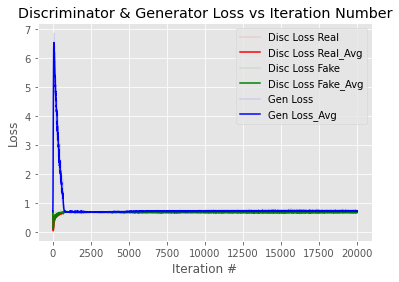

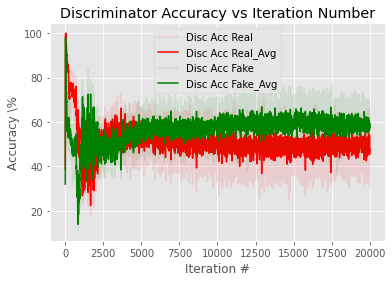

INFO:tensorflow:Assets written to: saved_model/EV+EnergySystem_generator_model.tf/assets
INFO:tensorflow:Assets written to: saved_model/EV+EnergySystem_discriminator_model.tf/assets
INFO:tensorflow:Assets written to: saved_model/EV+EnergySystem_combined_model.tf/assets


In [26]:
# Train the CGAN and generate outputs
latent_dim = 22
cgan = CGAN(X_train, y_train, X_test, y_test, X_Scaler, y_Scaler, latent_dim=latent_dim)
# Long runs
cgan.train(epochs=20000, batch_size=256, sample_interval=400, runningAvgDur=10)

# if long_run:
#     if experiment in ['WorstHalfLCC', 'WorstHalfCO2']: # ~155 epochs
#       cgan.train(epochs=20000, batch_size=256, sample_interval=1000, runningAvgDur=10)
#     elif experiment in ['WorstHalfWalkScore']: # ~155 epoch
#       cgan.train(epochs=24000, batch_size=256, sample_interval=1000, runningAvgDur=10) 
#     elif experiment == 'FullData':# ~156 epochs
#       cgan.train(epochs=40000, batch_size=256, sample_interval=1000, runningAvgDur=10) # 256 iterations ~= 1 epoch for the full data # Tried at first batch of 64 over 10,000 epochs, it was good!
#     elif experiment == 'WorstHalfAll':# ~155 epochs
#       cgan.train(epochs=3200, batch_size=256, sample_interval=100, runningAvgDur=10) 
#     elif experiment == 'BestHalfAll':# ~155 epochs
#       cgan.train(epochs=5000, batch_size=256, sample_interval=150, runningAvgDur=10) 
# # Short runs:
# else:
#     if experiment in ['WorstHalfAll', 'BestHalfAll', 'FullData']:# ~16, 25 epochs
#       cgan.train(epochs=2000, batch_size=64, sample_interval=100, runningAvgDur=10) 
#     elif experiment in ['WorstHalfWalkScore', 'WorstHalfLCC', 'WorstHalfCO2']: # ~1 epoch
#       cgan.train(epochs=800, batch_size=64, sample_interval=100, runningAvgDur=10)

In [13]:
# Copy all the images to Data directory to be processed by the evaluation function
from shutil import copyfile

if not os.path.isdir('./Data/'):
  os.mkdir('./Data/')

for filename in os.listdir('./images/'):
    if run_name in filename and '.txt' in filename: # i.e. if the file is a results file for this run_name
      copyfile('./images/'+filename, './Data/'+filename)
print('Copied all generated results from images to Data directory')

Copied all generated results from images to Data directory


## Auxilliary: Generate more images using a saved TF model


In [ ]:
'''
from tensorflow.keras.models import load_model
os.chdir('./CGAN/')

def sample_images(generator, epoch, y_Scaler, X_Scaler):
  r, c = 125, 1
  noise = np.random.normal(0, 1, (r * c, latent_dim))

  sampled_labels = []

  # Experiment: getting the individuals with the best LCC
  for i in np.arange(-1.0, -1.25, -0.05):
    for j in np.arange(-1.0, 1.5, 0.5):
      for k in np.arange(-1.0, 1.5, 0.5):
        sampled_labels.append([i,j,k])
  

  gen_imgs = generator.predict([noise, np.array(sampled_labels)])
  scaled_gen_imgs = X_Scaler.inverse_transform(gen_imgs)

  np.savetxt("images/"+run_name+"_%d.txt" % epoch, scaled_gen_imgs)


generator = load_model(filepath='./saved_model/'+run_name+'_generator_model.tf')
sample_images(generator, epoch=1, y_Scaler=y_Scaler, X_Scaler=X_Scaler)
'''

'\nfrom tensorflow.keras.models import load_model\nos.chdir(\'./CGAN/\')\n\ndef sample_images(generator, epoch, y_Scaler, X_Scaler):\n  r, c = 125, 1\n  noise = np.random.normal(0, 1, (r * c, latent_dim))\n\n  sampled_labels = []\n\n  # Experiment: getting the individuals with the best LCC\n  for i in np.arange(-1.0, -1.25, -0.05):\n    for j in np.arange(-1.0, 1.5, 0.5):\n      for k in np.arange(-1.0, 1.5, 0.5):\n        sampled_labels.append([i,j,k])\n  \n\n  gen_imgs = generator.predict([noise, np.array(sampled_labels)])\n  scaled_gen_imgs = X_Scaler.inverse_transform(gen_imgs)\n\n  np.savetxt("images/"+run_name+"_%d.txt" % epoch, scaled_gen_imgs)\n\n\ngenerator = load_model(filepath=\'./saved_model/\'+run_name+\'_generator_model.tf\')\nsample_images(generator, epoch=1, y_Scaler=y_Scaler, X_Scaler=X_Scaler)\n'

# 2 Evaluate the generated solutions

## 2.1 Initialize

In [9]:
!pip install pipreqs
!pipreqs . --force
!pip install -r requirements.txt

INFO: Successfully saved requirements file in ./requirements.txt
     |████████████████████████████████| 163kB 5.0MB/s 
     |████████████████████████████████| 3.7MB 8.3MB/s 
     |████████████████████████████████| 604kB 28.7MB/s 
     |████████████████████████████████| 245kB 43.0MB/s 
  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18178 sha256=3dbb38579261c60d87e427d5e58a058cf1dd64122a2d30727a31f2a6a9d41dec
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
  Created wheel for pymoo: filename=pymoo-0.4.2.2-cp37-cp37m-linux_x86_64.whl size=4939850 sha256=2f0873162140a2589cb1d8ad4d287964c060cb0f49fc6f7cb8afbad24654d9d1
  Stored in directory: /root/.cache/pip/wheels/95/13/7a/b9489d4dc66ef0b7d03f6cc3be7535b9b2f18d83893437ad7c
  Created wheel for scoop: filename=scoop-0.7.1.1-cp37-none-any.whl size=72125 sha256=567a15eeccd3384ad70aee06d9cc6153948edd4c1d9c5043e23fa001b326dfeb
  Stored in directory: /root/.cache/

In [14]:
# Constants for plotting the filtered plots
LCC_Cutoff = 100 # k$/m2
CO2_Cutoff = 10 # T-CO2/m2



# Constants for evaluating the solutions
len_of_indiv = len(X_train[0])



# Load the libraries
import sys
import os
Ch3_Dir = '/content/drive/MyDrive/GAN_GA_100_Percent_EV_Shared/GAN_GA_100_Percent_EV_Shared/Simulation'
sys.path.append(Ch3_Dir)

os.chdir(Ch3_Dir)
from Main import SupplyandDemandOptimization as analyze, Num_Engines,\
                Num_Chillers, Building_Min, Supply_Min, Low_Seq, High_Seq
os.chdir('/content/drive/MyDrive/GAN_GA_100_Percent_EV_Shared/GAN_GA_100_Percent_EV_Shared')

from Plots_Paper_One import DF_Filter
from matplotlib import pyplot as plt

from tqdm import tqdm

## 2.2 Helper functions

In [15]:
## Helper function for loading the filenames of the results
def load_filenames(experiment):
  # TO DO: TODO use the results from images/<run_name>_*.txt
  fileNames = []
  for filename in os.listdir('./images/'):
    if run_name in filename and '.txt' in filename: # i.e. if the file is a results file for this run_name
      fileNames.append(filename[:-4])
  return fileNames

## 2.3 Main

  0%|          | 0/32800 [00:00<?, ?it/s]

Saved rebuilt data generated by GAN into ./Data/rebuilt_EV+EnergySystem_400.txt


100%|██████████| 32800/32800 [3:27:04<00:00,  2.64it/s]




++++++++++++++++++++++++++
Number of corrected individuals: 0 out of 32800
Number of ignored individuals: 674 out of 32800
Saved points generated by GAN and their associated results into ./Data/resultsTotalEV+EnergySystem_400.txt
loading data generated by the optimization algorithm
+++++ processing Results_EV_100_Percent.csv +++++

Count duplicates:
75896
Count under the min GFA:
0
Count over the max GFA:
11800
Count over the max Site GFA:
20077
Count valid answers:
162841

Plotting!

Plotting LCC vs CO2


+++++
Find duplicate elements b/w the original and the synthetic individuals
Number of elements shared between the original and the synthetic data: 2005
List of elements shared between the original and the synthetic data (indices defined): 2005
lowest LCC in generated individuals: 38.61
lowest LCC in training individuals: 38.59
--> Percent improvement: -0.1%
Lowest CO2 in generated data: 0.0051
Lowest CO2 in training data: 0.0066
--> Percent improvement: 22.7%
++++
Filtering DF and

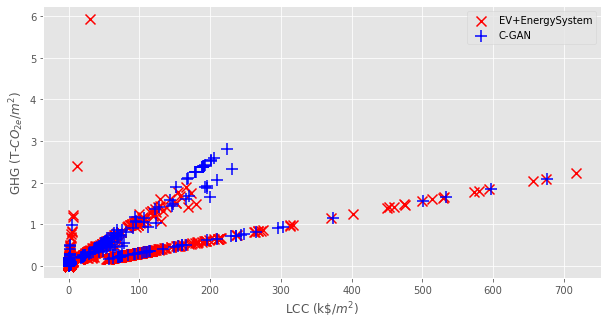

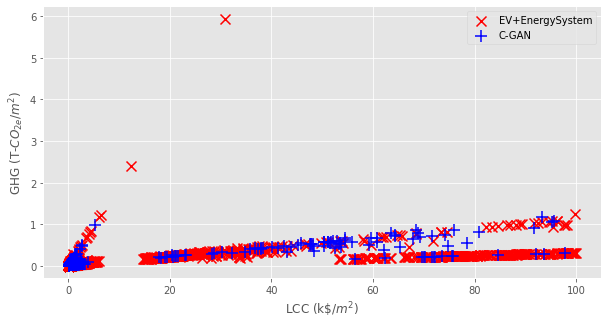

In [16]:
os.chdir('/content/drive/MyDrive/GAN_GA_100_Percent_EV_Shared/GAN_GA_100_Percent_EV_Shared')
# DECLARE THE EXPERIMENT TYPE
plot_only = False # If you want no evaluation and simply plotting the results, set this to True; no plots are made when this is False
stats_and_plot = True # If you want statistical info to be printed out while plot_only is True, set this to True
aggregate_results = False # If you want the results of the long and short runs to get combined, set this to be True
verbose = True # If you want full outputs to be printed out, set this to True


plt.close('all')
# Load the proper set of filenames based on the experiment
fileNames = load_filenames(experiment)


# Read in the data generated by GAN or load the already processed dataset
if not plot_only:
    if not os.path.exists('./Data/rebuilt_'+fileNames[0]+'.txt'):
        # If more than one filename provided, combine them and save them as one
        loadedData = np.round(np.loadtxt('./Data/'+fileNames[0]+'.txt'))
        for name in fileNames[1:]:
            loadedData = np.append(loadedData, np.round(np.loadtxt('./Data/'+name+'.txt')), axis=0)
            
        np.savetxt('./Data/rebuilt_'+fileNames[0]+'.txt', loadedData)
        print('Saved rebuilt data generated by GAN into %s'%('./Data/rebuilt_'+fileNames[0]+'.txt'))
    else:
        loadedData = np.loadtxt('./Data/rebuilt_'+fileNames[0]+'.txt')
        print('Loaded rebuilt data generated by GAN from %s'%('./Data/rebuilt_'+fileNames[0]+'.txt'))





# Evaluate the individuals or load the already-evaluated individuals
if not aggregate_results and not os.path.exists('./Data/resultsTotal'+fileNames[0]+'.txt'):
    # Evaluate the individuals
    resultsTotal = []
    correctedIndivs = 0 # Number of individuals corrected (meaning they were outside the allowed boundary)
    ignoredIndivs = 0 # Number of ignored individuals

    for indiv in tqdm(loadedData):
        indiv = list(indiv)
        # Fit the generated individual inside the High_Seq - Low_Seq range
        oldIndiv = indiv
        
        # Check the validity of the DNA and round to the nearest valid number
        indiv = list(np.minimum(np.maximum(indiv, Low_Seq), High_Seq))
        
        # Check if there are any buildings in the development
        if np.sum(indiv[:4]) == 0:
            ignoredIndivs += 1
            continue
        
        # Register if the individual has been corrected
        if indiv != oldIndiv:
            correctedIndivs += 1

        results = analyze(indiv)

        # Skip trivial cases
        if float('inf') in results[0] or -float('inf') in results[0]: 
            ignoredIndivs += 1
            continue

        [LCC_per_GFA, CO2_per_GFA] = results[0]
        if LCC_per_GFA != float('inf'):
            indiv.extend(results[0])
            resultsTotal.append(indiv)

    print('\n\n++++++++++++++++++++++++++\nNumber of corrected individuals: %d out of %d'%(correctedIndivs, len(loadedData)))
    print('Number of ignored individuals: %d out of %d'%(ignoredIndivs, len(loadedData)))

    np.savetxt('./Data/resultsTotal'+fileNames[0]+'.txt', resultsTotal)
    print('Saved points generated by GAN and their associated results into %s'%('./Data/resultsTotal'+fileNames[0]+'.txt'))

else:
    if not aggregate_results:
        resultsTotal = np.loadtxt('./Data/resultsTotal'+fileNames[0]+'.txt')
        print('Loaded points generated by GAN from %s'%('./Data/resultsTotal'+fileNames[0]+'.txt'))
    else:
        resultsTotal = load_combined_results(experiment)

resultsTotal = np.array(resultsTotal)
    
    
    
    
    
    
if verbose: print('loading data generated by the optimization algorithm')
filename = result_file_name
DFName = run_name
if plot_only or stats_and_plot:
    DF = DF_Filter(filename)
else:
    DF = DF_Filter(filename)


plt.style.use('ggplot')
colors_rb = {DFName:'r'}

#############################################

if plot_only or stats_and_plot:
    if verbose: print('\nPlotting!\n')


    # LCC vs CO2
    if verbose: print('Plotting LCC vs CO2')
    plt.figure(figsize=(10,5))
    plt.scatter(x=DF[LCC_Var]/10**3,y=DF[CO2_Var], label=DFName, s=100, alpha=1, c=colors_rb[DFName], marker='x')
    plt.scatter(x=resultsTotal[:,len_of_indiv+0]/10**3, y=resultsTotal[:,len_of_indiv+1], label='C-GAN', s=150, alpha=1, c='blue', marker='+')
    
    plt.xlabel(r'LCC (k\$/$m^2$)')
    plt.ylabel(r'GHG (T-$CO_{2e}$/$m^2$)')
    plt.legend()
    
    if not os.path.isdir('Figures/'):
      os.mkdir('Figures/')

    plt.savefig('./Figures/All_CO2_vs_LCC'+fileNames[0]+'.png', dpi=400, bbox_inches='tight')
    




if not plot_only or stats_and_plot:
    # FIND DUPLICATE ELEMENTS B/W The original and the synthetic individuals
    if verbose: print('\n\n+++++\nFind duplicate elements b/w the original and the synthetic individuals')
    original_data = np.array(DF.iloc[:,:13])
    original_data = np.concatenate((original_data[:,:7], original_data[:,9:]),axis=1)
    list_original_data = [list(item) for item in original_data]
    
    
    synth_data = resultsTotal[:,:11]
    list_synth_data = [list(item) for item in synth_data]
    
    duplicates = []
    for i in range(len(synth_data)):
        if list_synth_data[i] in list_original_data:
            duplicates.append(i)
            
    if verbose: print('Number of elements shared between the original and the synthetic data: %d'%len(duplicates))
    if duplicates:
         print('List of elements shared between the original and the synthetic data (indices defined): %d'%len(duplicates))






    # Check the improvement in targeted objective function compared to the training data
    
    lowest_generated = np.min(resultsTotal[:,len_of_indiv+0])
    lowest_training = np.min(DF[LCC_Var])
    print('lowest LCC in generated individuals: %.2f'%lowest_generated)
    print('lowest LCC in training individuals: %.2f'%lowest_training)
    print('--> Percent improvement: %.1f%%'%((lowest_training-lowest_generated)/lowest_training*100))
    
    lowest_generated = np.min(resultsTotal[:,len_of_indiv+1])
    lowest_training = np.min(DF[CO2_Var])
    print('Lowest CO2 in generated data: %.4f'%lowest_generated)
    print('Lowest CO2 in training data: %.4f'%lowest_training)
    print('--> Percent improvement: %.1f%%'%((lowest_training-lowest_generated)/lowest_training*100))
    




if plot_only or stats_and_plot:
    # LCC vs CO2 (Filtered below the cutoff thresholds)
    # Filter dataframes based on max values of CO2 and LCC
    if verbose: print('++++\nFiltering DF and resultsTotal based on cutoffs (LCC_Cutoff: %d, CO2_Cutoff: %d)'%(LCC_Cutoff, CO2_Cutoff))
    DF = DF[DF[LCC_Var]/10**3 <= LCC_Cutoff]
    DF = DF[DF[CO2_Var] <= CO2_Cutoff] # Observation: with a less than $500k/m2 of LCC, no designs have CO2/m2 higher than 5 T-CO2/m2
    resultsTotal = resultsTotal[resultsTotal[:,len_of_indiv+0]/10**3 <= LCC_Cutoff]
    resultsTotal = resultsTotal[resultsTotal[:,len_of_indiv+1] <= CO2_Cutoff]
    
    
    
    if verbose: print('Plotting LCC vs CO2')
    plt.figure(figsize=(10,5))
    plt.scatter(x=DF[LCC_Var]/10**3,y=DF[CO2_Var], label=DFName, s=100, alpha=1, c=colors_rb[DFName], marker='x')
    plt.scatter(x=resultsTotal[:,len_of_indiv+0]/10**3, y=resultsTotal[:,len_of_indiv+1], label='C-GAN', s=150, alpha=1, c='blue', marker='+')
    
    plt.xlabel(r'LCC (k\$/$m^2$)')
    plt.ylabel(r'GHG (T-$CO_{2e}$/$m^2$)')
    plt.legend()
    if not os.path.isdir('Figures/'):
      os.mkdir('Figures/')
    plt.savefig('./Figures/CO2_vs_LCC'+fileNames[0]+'.png', dpi=400, bbox_inches='tight')

## 2.4 Calculate the changes in hypervolume

In [17]:

ref_point = [1.0, 1.0] # Reference point for calculating the hypervolume

## Labels for the generated dataset
LCC_Var_Gen = len_of_indiv+0
CO2_Var_Gen = len_of_indiv+1

np.random.seed(42)
   
# Calculate the hypervolume
resultsTotal = pd.DataFrame(resultsTotal)
## modify the input parameters to make them suitable for calculating the HV w.r.t. the reference point (1,1,1)
maxLCC = max(np.max(DF[LCC_Var]), np.max(resultsTotal[LCC_Var_Gen]))
maxCO2 = max(np.max(DF[CO2_Var]), np.max(resultsTotal[CO2_Var_Gen]))
   
minLCC = min(np.min(DF[LCC_Var]), np.min(resultsTotal[LCC_Var_Gen]))
minCO2 = min(np.min(DF[CO2_Var]), np.min(resultsTotal[CO2_Var_Gen]))
   
## Normalize the generated and training data to 0 to 1 range
def normalize_data(df, column, minValue, maxValue):
  df[column] = (df[column] - minValue)/(maxValue - minValue)
   
newDF = DF[[LCC_Var, CO2_Var]]
normalize_data(newDF, LCC_Var, minLCC, maxLCC)
normalize_data(newDF, CO2_Var, minCO2, maxCO2)
   
normalize_data(resultsTotal, LCC_Var_Gen, minLCC, maxLCC)
normalize_data(resultsTotal, CO2_Var_Gen, minCO2, maxCO2)
   
## Calculate the hv
from pymoo.factory import get_performance_indicator
hv = get_performance_indicator("hv", ref_point=np.array(ref_point))
   
## GIVES MEMORY ERROR IF USED DIRECTLY ##
array1 = np.array(newDF[[LCC_Var, CO2_Var]])
   
array2 = np.array(resultsTotal[[LCC_Var_Gen, CO2_Var_Gen]])
generatedArea = hv.calc(array2)
   
originalAreas = []
# prevArr = None
Num_Samplings = np.minimum(100, int(len(array1)/len(array2))+1)
for i in range(Num_Samplings):
  choices = np.random.randint(low=0, high=len(array1), size=len(array2))
  array1_2 = np.array(newDF[[LCC_Var, CO2_Var]])[choices, :]
  originalAreas.append(hv.calc(array1_2))
   
meanOriginalArea = np.mean(originalAreas)
maxOriginalArea = np.max(originalAreas)
   
print('Generated hv:%.2e'%generatedArea)
print('Maximum original hv:%.2e'%maxOriginalArea)
print('Mean original hv:%.2e'%meanOriginalArea)
if generatedArea > meanOriginalArea:
  print('Generated solutions have on average a hv %.2f%% larger than the original solutions'%((generatedArea - meanOriginalArea)/meanOriginalArea*100))
else:
  print('Original solutions have on average a hv %.2f%% larger than the generated solutions'%((meanOriginalArea - generatedArea)/meanOriginalArea*100))
       
if generatedArea > maxOriginalArea:
  print('Generated solutions have a hv %.2f%% larger than the best of original solutions'%((generatedArea - maxOriginalArea)/maxOriginalArea*100))
else:
  print('Original solutions have at best a hv %.2f%% larger than the generated solutions'%((maxOriginalArea - generatedArea)/maxOriginalArea*100))



# Constants
#ref_point = [1.0, 1.0] # Reference point for calculating the hypervolume


## Labels for the generated dataset
#LCC_Var_Gen = len_of_indiv+0
#CO2_Var_Gen = len_of_indiv+1

#np.random.seed(42)



# DECLARE THE EXPERIMENT TYPE
#aggregate_results = True
#print('\n+++++++++++++++++')
#print('Results for the experiment %s:\n'%experiment)

# Load the proper set of filenames based on the experiment
#ileNames = load_filenames(experiment)



# Load the datasets
# if not aggregate_results:
#resultsTotal = pd.DataFrame(np.loadtxt('./Data/resultsTotal'+fileNames[0]+'.txt'))
#print('Loaded points generated by GAN from %s'%('./Data/resultsTotal'+fileNames[0]+'.txt'))
# else:
#     resultsTotal = pd.DataFrame(load_combined_results(experiment))

#filename = result_file_name
#DF = DF_Filter(filename)



# Calculate the hypervolume
## modify the input parameters to make them suitable for calculating the HV w.r.t. the reference point (1,1,1)
#maxLCC = max(np.max(DF[LCC_Var]), np.max(resultsTotal[LCC_Var_Gen]))
#maxCO2 = max(np.max(DF[CO2_Var]), np.max(resultsTotal[CO2_Var_Gen]))

#minLCC = min(np.min(DF[LCC_Var]), np.min(resultsTotal[LCC_Var_Gen]))
#minCO2 = min(np.min(DF[CO2_Var]), np.min(resultsTotal[CO2_Var_Gen]))


## Normalize the data to 0 to 1
#def normalize_data(DF, column, minValue, maxValue):
#    DF[column] = (DF[column] - minValue)/(maxValue - minValue)

#normalize_data(DF, LCC_Var, minLCC, maxLCC)
#normalize_data(DF, CO2_Var, minCO2, maxCO2)

#normalize_data(resultsTotal, LCC_Var_Gen, minLCC, maxLCC)
#normalize_data(resultsTotal, CO2_Var_Gen, minCO2, maxCO2)



## Calculate the hv
#from pymoo.factory import get_performance_indicator
#hv = get_performance_indicator("hv", ref_point=np.array(ref_point))


## GIVES MEMORY ERROR IF USED DIRECTLY ##
#array1 = np.array(DF[[LCC_Var, CO2_Var]])


#array2 = np.array(resultsTotal[[LCC_Var_Gen, CO2_Var_Gen]])
#generatedArea = hv.calc(array2)


#originalAreas = []
# prevArr = None
#Num_Samplings = int(len(array1)/len(array2))+1
#for i in range(Num_Samplings):
#    choices = np.random.randint(low=0, high=len(array1), size=len(array2))
#    array1_2 = np.array(DF[[LCC_Var, CO2_Var]])[choices, :]
#    originalAreas.append(hv.calc(array1_2))

#meanOriginalArea = np.mean(originalAreas)
#maxOriginalArea = np.max(originalAreas)

  
#print('Maximum generated hv:%.2e'%generatedArea)
#print('Maximum original hv:%.2e'%maxOriginalArea)
#print('Mean original hv:%.2e'%meanOriginalArea)
#if generatedArea > meanOriginalArea:
#    print('Generated solutions have on average a hv %.2f%% larger than the original solutions'%((generatedArea - meanOriginalArea)/meanOriginalArea*100))
#else:
#    print('Original solutions have on average a hv %.2f%% larger than the generated solutions'%((meanOriginalArea - generatedArea)/meanOriginalArea*100))
    
    
#if generatedArea > maxOriginalArea:
#    print('Generated solutions have a hv %.2f%% larger than the best of original solutions'%((generatedArea - maxOriginalArea)/maxOriginalArea*100))
#else:
#    print('Original solutions have at best a hv %.2f%% larger than the generated solutions'%((maxOriginalArea - generatedArea)/maxOriginalArea*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Generated hv:1.00e+00
Maximum original hv:1.00e+00
Mean original hv:1.00e+00
Generated solutions have on average a hv 0.03% larger than the original solutions
Generated solutions have a hv 0.03% larger than the best of original solutions
